 ## Download the Dataset and Understand the Format

In [ ]:
import kagglehub
path = kagglehub.dataset_download("kasikrit/att-database-of-faces")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/att-database-of-faces


In [ ]:
import os
data_directory = os.path.join(path, "/kaggle/input/att-database-of-faces")
subjects = [f for f in os.listdir(data_directory) if f.startswith("s")]
subjects.sort(key=lambda s: int(s[1:]))
print("Subjects in the dataset are:",subjects)

Subjects in the dataset are: ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21', 's22', 's23', 's24', 's25', 's26', 's27', 's28', 's29', 's30', 's31', 's32', 's33', 's34', 's35', 's36', 's37', 's38', 's39', 's40']


 ## Generate the Data Matrix and the Label vector

In [ ]:
import numpy as np
from PIL import Image

D = []
y = []
for i, subject in enumerate(subjects, start=1):
    subject_path = os.path.join(data_directory, subject)
    for img_name in os.listdir(subject_path):
        img_path = os.path.join(subject_path, img_name)
        img = Image.open(img_path).convert('L')
        img_vector = np.array(img).flatten()
        D.append(img_vector)
        y.append(i)

D = np.array(D)
y = np.array(y)
print("Data matrix shape:", D.shape)
print("Label vector shape:", y.shape)

Data matrix shape: (400, 10304)
Label vector shape: (400,)


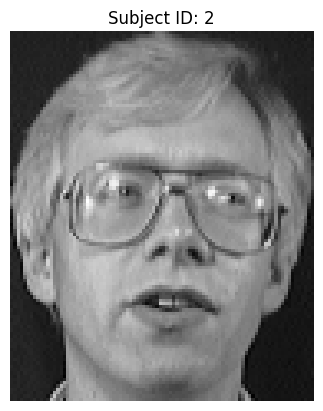

In [ ]:
import matplotlib.pyplot as plt
index = 18
img = D[index].reshape((112, 92))
plt.imshow(img, cmap='gray')
plt.title(f"Subject ID: {y[index]}")
plt.axis('off')
plt.show()

## Split the Dataset into Training and Test sets

In [ ]:
X_train = D[::2]
X_test = D[1::2]
y_train = y[::2]
y_test = y[1::2]

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Training set shape: (200, 10304)
Test set shape: (200, 10304)
Training labels shape: (200,)
Test labels shape: (200,)


## PCA Implementation

In [ ]:
def pca(X, variance_threshold=0.95, save_eigvals_path=None):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    cov_matrix = np.cov(X_centered, rowvar=False)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    if save_eigvals_path:
        np.save(save_eigvals_path, eigvals)

    total_var = np.sum(eigvals)
    var_ratio = np.cumsum(eigvals) / total_var
    num_components = np.searchsorted(var_ratio, variance_threshold) + 1

    projection_matrix = eigvecs[:, :num_components]
    X_reduced = np.dot(X_centered, projection_matrix)

    return X_reduced, projection_matrix, X_mean, num_components

### note: next cell might take around 20 minutes running


=== PCA with alpha = 0.8 ===
Retained dimensions: 35


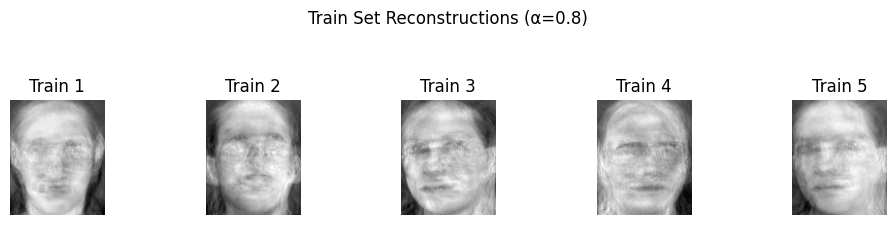

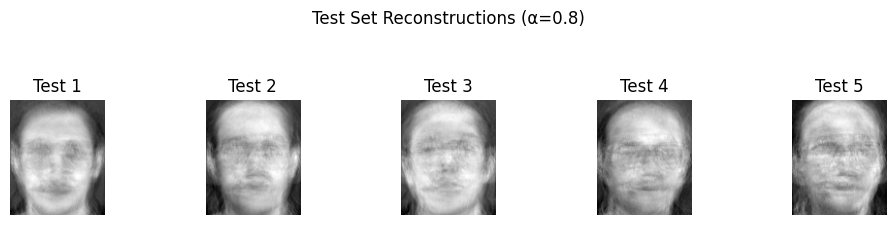


=== PCA with alpha = 0.85 ===
Retained dimensions: 51


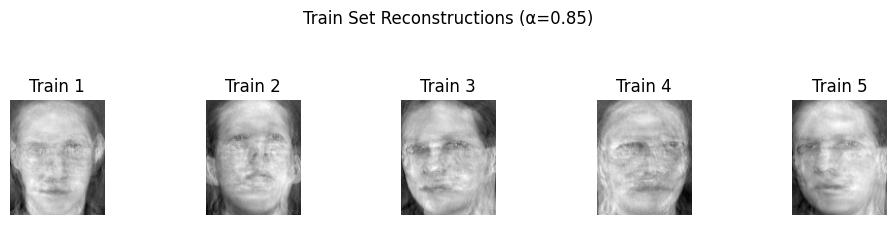

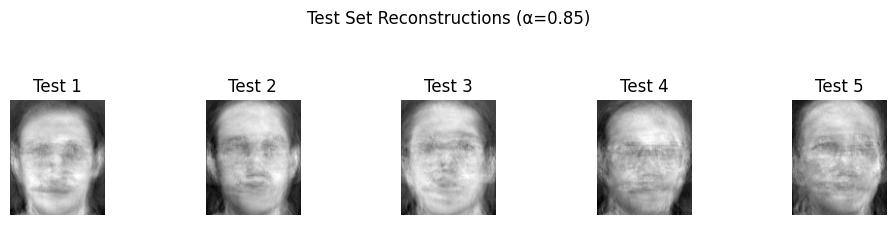


=== PCA with alpha = 0.9 ===
Retained dimensions: 75


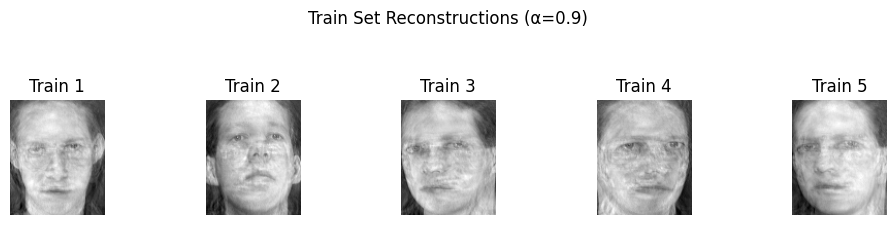

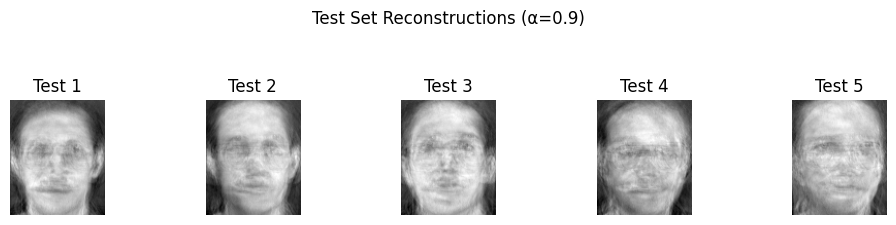


=== PCA with alpha = 0.95 ===
Retained dimensions: 114


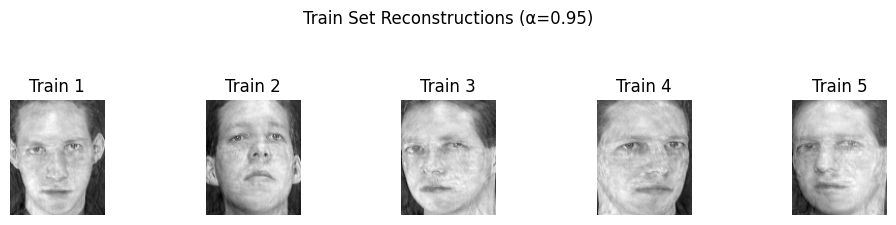

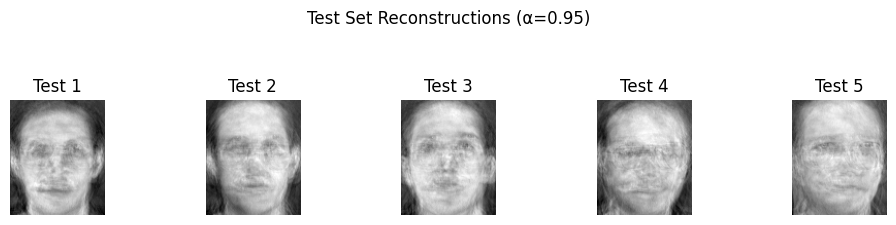

In [ ]:
os.makedirs("pca_outputs", exist_ok=True)
alphas = [0.8, 0.85, 0.9, 0.95]

for alpha in alphas:
    print(f"\n=== PCA with alpha = {alpha} ===")

    X_train_pca, P, X_mean, dim = pca(
        X_train,
        variance_threshold=alpha,
        save_eigvals_path=f"pca_outputs/eigvals_{alpha}.npy"
    )
    print(f"Retained dimensions: {dim}")

    X_test_centered = X_test - X_mean
    X_test_pca = np.dot(X_test_centered, P)

    np.save(f"pca_outputs/X_train_pca_{alpha}.npy", X_train_pca)
    np.save(f"pca_outputs/X_test_pca_{alpha}.npy", X_test_pca)
    np.save(f"pca_outputs/P_{alpha}.npy", P)
    np.save(f"pca_outputs/X_mean_{alpha}.npy", X_mean)
    np.save("pca_outputs/y_train.npy", y_train)
    np.save("pca_outputs/y_test.npy", y_test)

    X_train_reconstructed = np.dot(X_train_pca, P.T) + X_mean
    X_test_reconstructed = np.dot(X_test_pca, P.T) + X_mean

    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        axs[i].imshow(X_train_reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].set_title(f"Train {i+1}")
        axs[i].axis('off')
    plt.suptitle(f"Train Set Reconstructions (α={alpha})", y=1.1)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 5, figsize=(10, 2))
    for i in range(5):
        axs[i].imshow(X_test_reconstructed[i].reshape((112, 92)), cmap='gray')
        axs[i].set_title(f"Test {i+1}")
        axs[i].axis('off')
    plt.suptitle(f"Test Set Reconstructions (α={alpha})", y=1.1)
    plt.tight_layout()
    plt.show()

In [ ]:
# to load the data from files
alpha = 0.95
X_train_pca = np.load(f"pca_outputs/X_train_pca_{alpha}.npy")
X_test_pca = np.load(f"pca_outputs/X_test_pca_{alpha}.npy")
y_train = np.load("pca_outputs/y_train.npy")
y_test = np.load("pca_outputs/y_test.npy")

In [ ]:
X_train_pca_9 = np.load("pca_outputs/X_train_pca_0.9.npy")
X_test_pca_9 = np.load("pca_outputs/X_test_pca_0.9.npy")

X_train_pca_85 = np.load("pca_outputs/X_train_pca_0.85.npy")
X_test_pca_85 = np.load("pca_outputs/X_test_pca_0.85.npy")

X_train_pca_8 = np.load("pca_outputs/X_train_pca_0.8.npy")
X_test_pca_8 = np.load("pca_outputs/X_test_pca_0.8.npy")

## Gaussian Mixture Model Clustering

In [ ]:
from scipy.stats import multivariate_normal

class Gaussian:
  def __init__(self, mu, sigma, pi):
    self.mu = mu
    self.sigma = sigma
    self.pi = pi

  def pdf(self, data):
    cov_inverse = np.linalg.inv(self.sigma)
    cov_det = np.linalg.det(self.sigma)
    constant_term = 1.0 / np.sqrt(((2*np.pi)**data.shape[1]) * cov_det)
    X_zero_mean = data - self.mu
    exponent_term = np.exp(-0.5 * np.sum(X_zero_mean.dot(cov_inverse) * X_zero_mean ,axis=1))
    return constant_term * exponent_term


In [ ]:
class GMM:
  def __init__(self, num_gaussians, max_iterations=100, tol=1e-4, reg_cov=1e-8, verbose=False):
    self.num_gaussians = num_gaussians
    self.max_iterations = max_iterations
    self.tol = tol
    self.reg_cov = reg_cov
    self.verbose = verbose
    self.gaussians = None

  def __setup(self, data):
    num_samples, num_features = data.shape
    self.gaussians = []
    self.__generate_random_gaussian(data)

  def __generate_random_gaussian(self, data):
    np.random.seed(42)
    mu_indecies = np.random.choice(data.shape[0], size=self.num_gaussians, replace=False)
    mus = data[mu_indecies]
    sigmas = np.array([np.cov(data, rowvar=False) + self.reg_cov * np.eye(data.shape[1]) for _ in range(self.num_gaussians)])
    pis = np.full(self.num_gaussians, 1 / self.num_gaussians)
    for i in range(self.num_gaussians):
      self.gaussians.append(Gaussian(mus[i], sigmas[i], pis[i]))

  def __expectation_step(self, data):
    # We calculate the postirior probability for each sample with each gauss model
    # postiriors = np.zeros((data.shape[0], self.num_gaussians))
    # for i in range(self.num_gaussians):
    #   postiriors[:, i] = self.gaussians[i].pdf(data) * self.gaussians[i].pi

    # row_sums = postiriors.sum(axis=1, keepdims=True)
    # row_sums[row_sums == 0] = np.finfo(float).eps
    # postiriors /= row_sums
    # np.set_printoptions(threshold=np.inf)

    # print(postiriors)
    # return postiriors
    log_resp = np.zeros((data.shape[0], self.num_gaussians))
    for i in range(self.num_gaussians):
      log_resp[:, i] = np.log(self.gaussians[i].pi) + self.gaussians[i].dist.logpdf(data)

    # Log-sum-exp trick
    max_log = np.max(log_resp, axis=1, keepdims=True)
    exp_log_resp = np.exp(log_resp - max_log)
    log_sum_exp = max_log + np.log(exp_log_resp.sum(axis=1, keepdims=True))

    responsibilities = exp_log_resp / np.exp(log_sum_exp)
    return responsibilities

  def __maximization_step(self, data, postiriors):
    column_sums = np.sum(postiriors, axis=0)

    # for i, g in enumerate(self.gaussians):
    #     if column_sums[i] < 1e-8:
    #         g.mu = data[np.random.choice(data.shape[0])]
    #         g.sigma = np.cov(data, rowvar=False) + self.reg_cov*np.eye(data.shape[1])
    #         g.pi = 1.0 / self.num_gaussians

    new_pis = column_sums / data.shape[0]

    for i in range(self.num_gaussians):
      self.gaussians[i].pi = new_pis[i]

    new_means = np.dot(postiriors.T, data) / column_sums[:, np.newaxis]
    for i in range(self.num_gaussians):
      self.gaussians[i].mu = new_means[i]

    for i in range(self.num_gaussians):
      diff = data - self.gaussians[i].mu
      weighted_diff = diff.T * postiriors[:, i]
      self.gaussians[i].sigma = np.dot(weighted_diff, diff) / column_sums[i]
      self.gaussians[i].sigma += np.eye(data.shape[1]) * self.reg_cov

  def __log_likelihood(self, data):
    likelihood = np.zeros((data.shape[0], self.num_gaussians))

    for i in range(self.num_gaussians):
      likelihood[:, i] = self.gaussians[i].pdf(data) * self.gaussians[i].pi

    likelihood[likelihood == 0] = np.finfo(float).eps
    return np.sum(np.log(np.sum(likelihood, axis=1)))

  def fit(self, data):
    self.__setup(data)
    prev_log_likelihood = None
    itr = self.max_iterations
    responsibilities = None

    while itr > 0:
      responsibilities = self.__expectation_step(data)
      self.__maximization_step(data, responsibilities)
      log_likelihood = self.__log_likelihood(data)

      if self.verbose:
        print(f"Log Likelihood: {log_likelihood}")

      if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < self.tol:
        if self.verbose:
          print(f"Converged after {self.max_iterations - itr} iterations")
        return

      prev_log_likelihood = log_likelihood
      itr -= 1

    if self.verbose:
      print(f"Model did not converge")

  def predict_soft(self, data):
    return self.__expectation_step(data)

  def predict_hard(self, data):
    return np.argmax(self.__expectation_step(data), axis=1)

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp


class GaussianMixtureModel:
    def __init__(self, n_components=2, max_iter=100, tol=1e-6, reg_covar=1e-4, verbose=False):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.verbose = verbose

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng()

        # Initialize weights equally
        self.weights_ = np.full(self.n_components, 1 / self.n_components)

        # Initialize means using random samples
        self.means_ = X[rng.choice(n_samples, self.n_components, replace=False)]

        # Initialize covariances to diagonal matrices
        self.covariances_ = np.array([np.cov(X.T) + self.reg_covar * np.eye(n_features)
                                      for _ in range(self.n_components)])

    def _estimate_log_gaussian_prob(self, X):
        log_prob = np.empty((X.shape[0], self.n_components))
        for k in range(self.n_components):
            mvn = multivariate_normal(mean=self.means_[k], cov=self.covariances_[k], allow_singular=True)
            log_prob[:, k] = mvn.logpdf(X)
        return log_prob

    def _e_step(self, X):
        log_prob = self._estimate_log_gaussian_prob(X)
        log_weighted_prob = log_prob + np.log(self.weights_)
        log_responsibilities = log_weighted_prob - logsumexp(log_weighted_prob, axis=1)[:, np.newaxis]
        return np.exp(log_responsibilities), log_responsibilities

    def _m_step(self, X, responsibilities):
        nk = responsibilities.sum(axis=0)
        self.weights_ = nk / X.shape[0]
        self.means_ = (responsibilities.T @ X) / nk[:, np.newaxis]

        self.covariances_ = np.zeros((self.n_components, X.shape[1], X.shape[1]))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_sum = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff
            self.covariances_[k] = weighted_sum / nk[k] + self.reg_covar * np.eye(X.shape[1])

    def fit(self, X):
        X = np.asarray(X)
        self._initialize_parameters(X)

        lower_bound = -np.inf
        for i in range(self.max_iter):
            responsibilities, log_resp = self._e_step(X)
            self._m_step(X, responsibilities)

            log_likelihood = np.sum(logsumexp(
                self._estimate_log_gaussian_prob(X) + np.log(self.weights_), axis=1
            ))

            change = log_likelihood - lower_bound
            if self.verbose:
                print(f"Iter {i+1}, Log Likelihood: {log_likelihood:.4f}, Change: {change:.6f}")
            if abs(change) < self.tol:
                break
            lower_bound = log_likelihood

    def predict_proba(self, X):
        log_prob = self._estimate_log_gaussian_prob(X)
        log_weighted_prob = log_prob + np.log(self.weights_)
        log_responsibilities = log_weighted_prob - logsumexp(log_weighted_prob, axis=1)[:, np.newaxis]
        return np.exp(log_responsibilities)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [ ]:
import numpy as np
from scipy.special import logsumexp
from sklearn.utils.extmath import row_norms
from sklearn.utils import check_random_state

class GaussianMixtureModel2:
    """
    Gaussian Mixture Model with full covariance matrices.

    Parameters
    ----------
    n_components : int, default=1
        Number of mixture components.
    max_iter : int, default=100
        Maximum number of EM iterations.
    tol : float, default=1e-3
        Convergence threshold. EM stops when log-likelihood gain is below tol.
    reg_covar : float, default=1e-6
        Regularization added to diagonal of covariance matrices.
    init_params : str, default='kmeans'
        Initialization method ('kmeans' or 'random').
    random_state : int or None, default=None
        Random seed for initialization.
    """

    def __init__(self, n_components=1, max_iter=100, tol=1e-3,
                 reg_covar=1e-6, init_kmeans=True, random_state=42):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.init_kmeans = init_kmeans
        self.random_state = random_state

    def _initialize(self, X):
        """Initialize parameters."""
        n_samples, n_features = X.shape
        random_state = check_random_state(self.random_state)

        if self.init_kmeans:
            from sklearn.cluster import KMeans
            kmeans = KMeans(n_clusters=self.n_components,
                           random_state=self.random_state).fit(X)
            self.means_ = kmeans.cluster_centers_
            self.weights_ = np.bincount(kmeans.labels_,
                                      minlength=self.n_components) / n_samples
        else:  # random
            self.means_ = X[random_state.choice(n_samples, self.n_components,
                                              replace=False)]
            self.weights_ = np.ones(self.n_components) / self.n_components

        # Initialize covariances to sample covariance with regularization
        cov = np.cov(X.T) + self.reg_covar * np.eye(n_features)
        self.covariances_ = np.tile(cov, (self.n_components, 1, 1))

    def _estimate_log_prob(self, X):
        """Estimate log probabilities using log-sum-exp trick."""
        n_samples, n_features = X.shape
        log_prob = np.empty((n_samples, self.n_components))

        for k in range(self.n_components):
            mean = self.means_[k]
            cov = self.covariances_[k]

            # Cholesky decomposition for numerical stability
            try:
                L = np.linalg.cholesky(cov)
            except np.linalg.LinAlgError:
                # Add regularization if Cholesky fails
                cov = cov + self.reg_covar * np.eye(n_features)
                L = np.linalg.cholesky(cov)

            # Mahalanobis distance using Cholesky
            X_centered = X - mean
            sol = np.linalg.solve(L, X_centered.T).T
            log_det = 2 * np.sum(np.log(np.diagonal(L)))

            # Log probability
            log_prob[:, k] = -0.5 * (n_features * np.log(2 * np.pi) +
                                    log_det + np.sum(sol**2, axis=1))

        return log_prob

    def _estimate_log_weights(self):
        """Estimate log of normalized weights."""
        return np.log(self.weights_ + np.finfo(float).eps)

    def _e_step(self, X):
        """E-step: compute responsibilities."""
        log_prob = self._estimate_log_prob(X)
        log_weights = self._estimate_log_weights()
        log_resp = log_prob + log_weights

        # Log-sum-exp trick for numerical stability
        log_prob_norm = logsumexp(log_resp, axis=1, keepdims=True)
        log_resp -= log_prob_norm

        # Compute statistics
        resp = np.exp(log_resp)
        weights = resp.sum(axis=0)
        weighted_X = resp.T @ X
        inverse_weights = 1.0 / (weights[:, np.newaxis] + 10 * np.finfo(float).eps)

        return resp, weights, weighted_X, log_prob_norm.sum()

    def _m_step(self, X, resp, weights, weighted_X):
        """M-step: update parameters."""
        n_samples, n_features = X.shape

        # Update weights
        self.weights_ = weights / n_samples

        # Update means
        self.means_ = weighted_X / weights[:, np.newaxis]

        # Update covariances
        self.covariances_ = np.empty((self.n_components, n_features, n_features))
        for k in range(self.n_components):
            diff = X - self.means_[k]
            weighted_diff = resp[:, k, np.newaxis] * diff
            cov = weighted_diff.T @ diff / weights[k]

            # Add regularization
            cov.flat[::n_features + 1] += self.reg_covar
            self.covariances_[k] = cov

    def fit(self, X):
        """Fit the model to data X."""
        self._initialize(X)
        prev_lower_bound = -np.inf

        for n_iter in range(self.max_iter):
            # E-step
            resp, weights, weighted_X, log_prob_norm = self._e_step(X)

            # M-step
            self._m_step(X, resp, weights, weighted_X)

            # Check convergence
            lower_bound = log_prob_norm
            change = lower_bound - prev_lower_bound
            if abs(change) < self.tol:
                break

            prev_lower_bound = lower_bound

        self.n_iter_ = n_iter + 1
        return self

    def predict_proba(self, X):
        """Predict posterior probabilities."""
        log_prob = self._estimate_log_prob(X)
        log_weights = self._estimate_log_weights()
        log_resp = log_prob + log_weights
        log_prob_norm = logsumexp(log_resp, axis=1, keepdims=True)
        log_resp -= log_prob_norm
        return np.exp(log_resp)

    def predict(self, X):
        """Predict cluster labels."""
        return self.predict_proba(X).argmax(axis=1)

In [ ]:
from collections import Counter

def cluster_majority_mapping(y_pred, y_true):
    mapping = {}
    for cluster in np.unique(y_pred):
        # indices of samples assigned to this cluster
        idx = np.where(y_pred == cluster)[0]
        # pick the most common true label among those
        true_labels = y_true[idx]
        most_common = Counter(true_labels).most_common(1)[0][0]
        mapping[cluster] = most_common
    return mapping

In [ ]:
def remap_predictions(y_pred, mapping):
    return np.array([mapping[c] for c in y_pred])

In [ ]:
# alpha = 0.95
number_of_gaussians = [20, 40, 60]

accuracy_alpha_95_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca)

  y_predict_train = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_95_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_95_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca)

  y_predict_train = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_95_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")



=== GMM with 20 components ===
Train Accuracy(Random): 0.225

=== GMM with 40 components ===
Train Accuracy(Random): 0.375

=== GMM with 60 components ===
Train Accuracy(Random): 0.525

=== GMM with 20 components ===
Train Accuracy(K-means): 0.41

=== GMM with 40 components ===
Train Accuracy(K-means): 0.73

=== GMM with 60 components ===
Train Accuracy(K-means): 0.855


In [ ]:
# alpha = 0.9

accuracy_alpha_9_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca_9)

  y_predict_train = gmm.predict(X_train_pca_9)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_9_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_9_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca_9)

  y_predict_train = gmm.predict(X_train_pca_9)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_9_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")



=== GMM with 20 components ===
Train Accuracy(Random): 0.29

=== GMM with 40 components ===
Train Accuracy(Random): 0.47

=== GMM with 60 components ===
Train Accuracy(Random): 0.61

=== GMM with 20 components ===
Train Accuracy(K-means): 0.395

=== GMM with 40 components ===
Train Accuracy(K-means): 0.725

=== GMM with 60 components ===
Train Accuracy(K-means): 0.885


In [ ]:
# alpha = 0.85

accuracy_alpha_85_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca_85)

  y_predict_train = gmm.predict(X_train_pca_85)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_85_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_85_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca)

  y_predict_train = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_85_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")



=== GMM with 20 components ===
Train Accuracy(Random): 0.365

=== GMM with 40 components ===
Train Accuracy(Random): 0.525

=== GMM with 60 components ===
Train Accuracy(Random): 0.695

=== GMM with 20 components ===
Train Accuracy(K-means): 0.41

=== GMM with 40 components ===
Train Accuracy(K-means): 0.73

=== GMM with 60 components ===
Train Accuracy(K-means): 0.855


In [ ]:
# alpha = 0.8

accuracy_alpha_8_random = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=False)
  gmm.fit(X_train_pca_8)

  y_predict_train = gmm.predict(X_train_pca_8)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_8_random.append(train_accuracy)
  print(f"Train Accuracy(Random): {train_accuracy}")

accuracy_alpha_8_kmeans = []
for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixtureModel2(n_components=k, init_kmeans=True)
  gmm.fit(X_train_pca_8)

  y_predict_train = gmm.predict(X_train_pca_8)
  gaussian_labels = cluster_majority_mapping(y_predict_train, y_train)
  y_predict_train_remap = remap_predictions(y_predict_train, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  accuracy_alpha_8_kmeans.append(train_accuracy)
  print(f"Train Accuracy(K-means): {train_accuracy}")



=== GMM with 20 components ===
Train Accuracy(Random): 0.4

=== GMM with 40 components ===
Train Accuracy(Random): 0.58

=== GMM with 60 components ===
Train Accuracy(Random): 0.725

=== GMM with 20 components ===
Train Accuracy(K-means): 0.435

=== GMM with 40 components ===
Train Accuracy(K-means): 0.725

=== GMM with 60 components ===
Train Accuracy(K-means): 0.88


In [ ]:
# Testing our implementation with the built-in

from sklearn.mixture import GaussianMixture

for k in number_of_gaussians:
  print(f"\n=== GMM with {k} components ===")
  gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
  gmm.fit(X_train_pca)

  labels = gmm.predict(X_train_pca)
  gaussian_labels = cluster_majority_mapping(labels, y_train)
  y_predict_train_remap = remap_predictions(labels, gaussian_labels)

  train_accuracy = np.mean(y_predict_train_remap == y_train)
  print(f"Train Accuracy: {train_accuracy}")



=== GMM with 20 components ===
Train Accuracy: 0.41

=== GMM with 40 components ===
Train Accuracy: 0.725

=== GMM with 60 components ===
Train Accuracy: 0.85


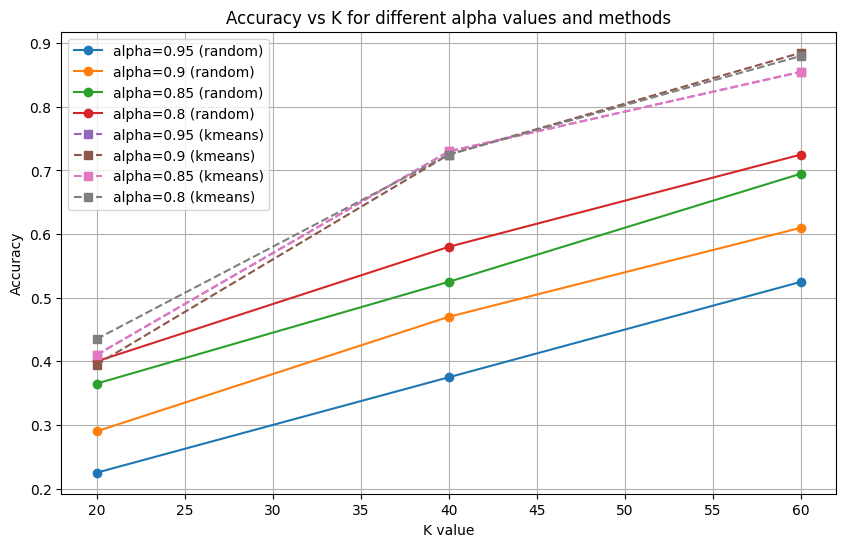

In [ ]:
# K values
K = [20, 40, 60]

# Plot
plt.figure(figsize=(10,6))

# Random method
plt.plot(K, accuracy_alpha_95_random, marker='o', label='alpha=0.95 (random)')
plt.plot(K, accuracy_alpha_9_random, marker='o', label='alpha=0.9 (random)')
plt.plot(K, accuracy_alpha_85_random, marker='o', label='alpha=0.85 (random)')
plt.plot(K, accuracy_alpha_8_random, marker='o', label='alpha=0.8 (random)')

# KMeans method
plt.plot(K, accuracy_alpha_95_kmeans, marker='s', linestyle='--', label='alpha=0.95 (kmeans)')
plt.plot(K, accuracy_alpha_9_kmeans, marker='s', linestyle='--', label='alpha=0.9 (kmeans)')
plt.plot(K, accuracy_alpha_85_kmeans, marker='s', linestyle='--', label='alpha=0.85 (kmeans)')
plt.plot(K, accuracy_alpha_8_kmeans, marker='s', linestyle='--', label='alpha=0.8 (kmeans)')

plt.xlabel('K value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K for different alpha values and methods')
plt.legend()
plt.grid(True)
plt.show()

## The relation between K and classification accuracy is as we increase the number of gaussians components we get better training accuracy.

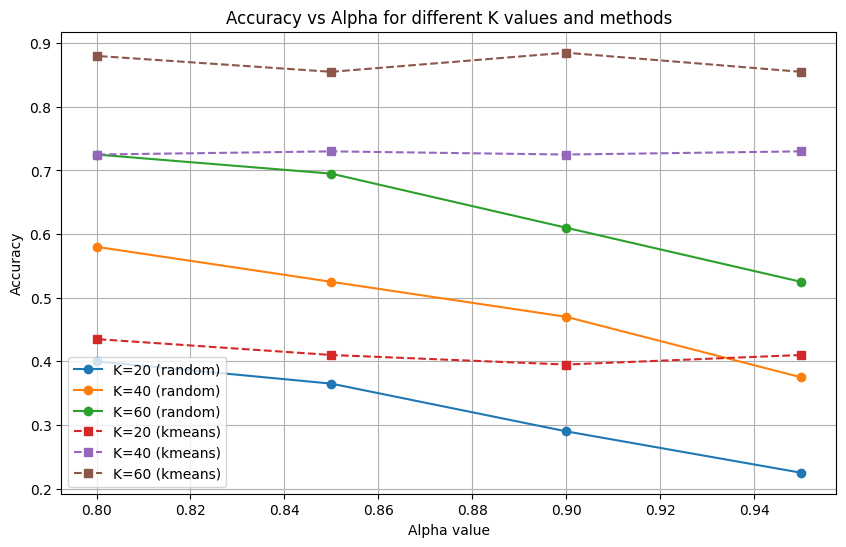

In [ ]:
alphas = [0.95, 0.9, 0.85, 0.8]

# For K = 20
accuracy_random_k20 = [accuracy_alpha_95_random[0], accuracy_alpha_9_random[0], accuracy_alpha_85_random[0], accuracy_alpha_8_random[0]]
accuracy_kmeans_k20 = [accuracy_alpha_95_kmeans[0], accuracy_alpha_9_kmeans[0], accuracy_alpha_85_kmeans[0], accuracy_alpha_8_kmeans[0]]

# For K = 40
accuracy_random_k40 = [accuracy_alpha_95_random[1], accuracy_alpha_9_random[1], accuracy_alpha_85_random[1], accuracy_alpha_8_random[1]]
accuracy_kmeans_k40 = [accuracy_alpha_95_kmeans[1], accuracy_alpha_9_kmeans[1], accuracy_alpha_85_kmeans[1], accuracy_alpha_8_kmeans[1]]

# For K = 60
accuracy_random_k60 = [accuracy_alpha_95_random[2], accuracy_alpha_9_random[2], accuracy_alpha_85_random[2], accuracy_alpha_8_random[2]]
accuracy_kmeans_k60 = [accuracy_alpha_95_kmeans[2], accuracy_alpha_9_kmeans[2], accuracy_alpha_85_kmeans[2], accuracy_alpha_8_kmeans[2]]

# Plot
plt.figure(figsize=(10,6))

# Random method
plt.plot(alphas, accuracy_random_k20, marker='o', label='K=20 (random)')
plt.plot(alphas, accuracy_random_k40, marker='o', label='K=40 (random)')
plt.plot(alphas, accuracy_random_k60, marker='o', label='K=60 (random)')

# KMeans method
plt.plot(alphas, accuracy_kmeans_k20, marker='s', linestyle='--', label='K=20 (kmeans)')
plt.plot(alphas, accuracy_kmeans_k40, marker='s', linestyle='--', label='K=40 (kmeans)')
plt.plot(alphas, accuracy_kmeans_k60, marker='s', linestyle='--', label='K=60 (kmeans)')

plt.xlabel('Alpha value')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha for different K values and methods')
plt.legend()
plt.grid(True)
plt.show()

## The relation between alpha and classification accuracy is that smaller values of alpha gives better training accuracy in case of random initialization but it seams steady in the case of K-means initialization.

In [ ]:
import pandas as pd

data = {
    'alpha': [0.95, 0.9, 0.85, 0.8],
    'random_K20': accuracy_random_k20,
    'random_K40': accuracy_random_k40,
    'random_K60': accuracy_random_k60,
    'kmeans_K20': accuracy_kmeans_k20,
    'kmeans_K40': accuracy_kmeans_k40,
    'kmeans_K60': accuracy_kmeans_k60,
}

df = pd.DataFrame(data)
print(df)


   alpha  random_K20  random_K40  random_K60  kmeans_K20  kmeans_K40  \
0   0.95       0.225       0.375       0.525       0.410       0.730   
1   0.90       0.290       0.470       0.610       0.395       0.725   
2   0.85       0.365       0.525       0.695       0.410       0.730   
3   0.80       0.400       0.580       0.725       0.435       0.725   

   kmeans_K60  
0       0.855  
1       0.885  
2       0.855  
3       0.880  


## GMM Evaluation

Accuracy: 0.7100
F1-Score: 0.6794


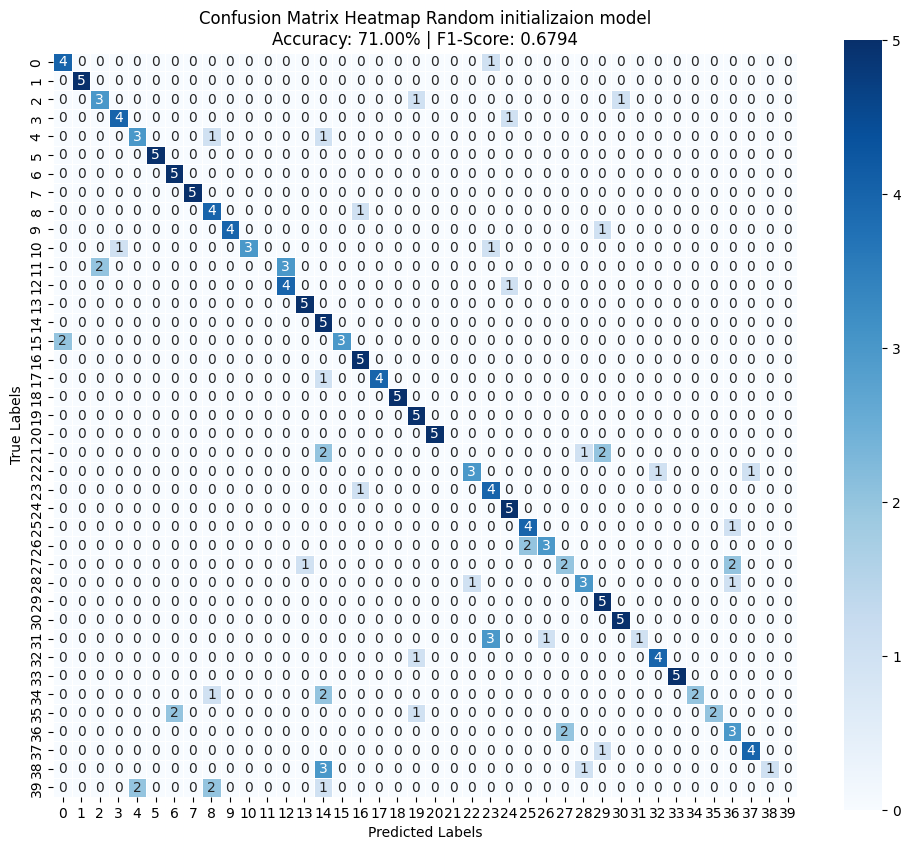

In [ ]:
# Random initializaion model

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

gmm = GaussianMixtureModel2(n_components=60, init_kmeans=False)
gmm.fit(X_train_pca_8)

y_predict_train = gmm.predict(X_test_pca_8)
gaussian_labels = cluster_majority_mapping(y_predict_train, y_test)
y_predict_test_remap = remap_predictions(y_predict_train, gaussian_labels)

accuracy = accuracy_score(y_test, y_predict_test_remap)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_predict_test_remap, average='macro')
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_predict_test_remap)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=True, linewidths=.5, square=True)

plt.title('Confusion Matrix Heatmap Random initializaion model\nAccuracy: {:.2f}% | F1-Score: {:.4f}'.format(accuracy*100, f1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Accuracy: 0.8000
F1-Score: 0.7971


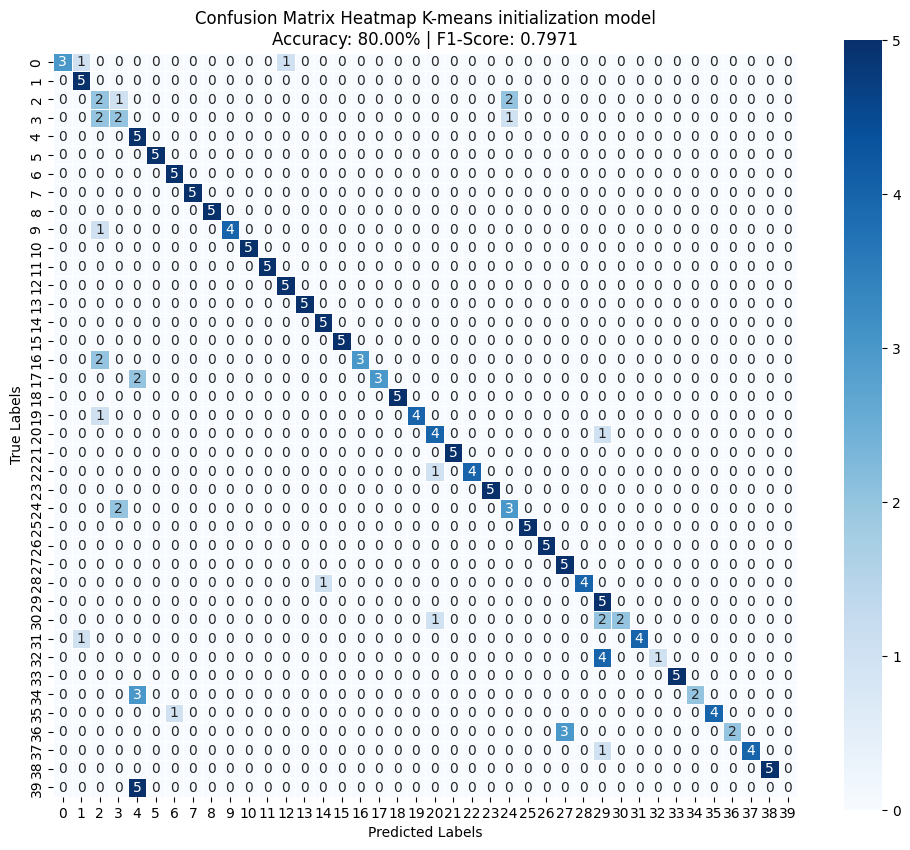

In [ ]:
# K-means initialization model

gmm = GaussianMixtureModel2(n_components=60, init_kmeans=True)
gmm.fit(X_train_pca_9)

y_predict_train = gmm.predict(X_test_pca_9)
gaussian_labels = cluster_majority_mapping(y_predict_train, y_test)
y_predict_test_remap = remap_predictions(y_predict_train, gaussian_labels)

accuracy = accuracy_score(y_test, y_predict_test_remap)
print(f"Accuracy: {accuracy:.4f}")

f1 = f1_score(y_test, y_predict_test_remap, average='macro')
print(f"F1-Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_predict_test_remap)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=True, linewidths=.5, square=True)

plt.title('Confusion Matrix Heatmap K-means initialization model\nAccuracy: {:.2f}% | F1-Score: {:.4f}'.format(accuracy*100, f1))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## Kmeans Clustering Implementation

## AutoEncoders Implementation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
input_dim = X_train.shape[1]
encoding_dim = 128
autoencoder = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
epochs = 1000
batch_size = 256

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

for epoch in range(epochs):
    autoencoder.train()
    permutation = torch.randperm(X_train_tensor.size(0))

    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i+batch_size]
        batch_data = X_train_tensor[indices]

        # Zeroing the gradients
        optimizer.zero_grad()

        # Forward pass
        reconstructed = autoencoder(batch_data)

        # Calculating the loss
        loss = criterion(reconstructed, batch_data)

        # Backpropagation
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [10/1000], Loss: 1909.6361
Epoch [20/1000], Loss: 1447.4159
Epoch [30/1000], Loss: 1371.5172
Epoch [40/1000], Loss: 1323.8663
Epoch [50/1000], Loss: 1207.1289
Epoch [60/1000], Loss: 1121.9735
Epoch [70/1000], Loss: 1069.0852
Epoch [80/1000], Loss: 1202.4996
Epoch [90/1000], Loss: 1017.4106
Epoch [100/1000], Loss: 985.7823
Epoch [110/1000], Loss: 947.3024
Epoch [120/1000], Loss: 881.2800
Epoch [130/1000], Loss: 820.0287
Epoch [140/1000], Loss: 801.5645
Epoch [150/1000], Loss: 785.8888
Epoch [160/1000], Loss: 773.9124
Epoch [170/1000], Loss: 759.8234
Epoch [180/1000], Loss: 733.5975
Epoch [190/1000], Loss: 716.3430
Epoch [200/1000], Loss: 697.0870
Epoch [210/1000], Loss: 677.3308
Epoch [220/1000], Loss: 658.0925
Epoch [230/1000], Loss: 638.3417
Epoch [240/1000], Loss: 631.3771
Epoch [250/1000], Loss: 605.6081
Epoch [260/1000], Loss: 587.3965
Epoch [270/1000], Loss: 570.7767
Epoch [280/1000], Loss: 556.2245
Epoch [290/1000], Loss: 573.8520
Epoch [300/1000], Loss: 541.3484
Epoch [310

In [ ]:
autoencoder.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10304, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10304, bias=True)
  )
)

In [ ]:
with torch.no_grad():
    original_images = X_train_tensor[:5]
    latent_features_train = autoencoder.encoder(X_train_tensor).numpy()
    latent_features_test = autoencoder.encoder(X_test_tensor).numpy()
    reconstructed_images = autoencoder(original_images)

print("shape of latent space for training data", latent_features_train.shape)
print("shape of latent space for testing data", latent_features_test.shape)

shape of latent space for training data (200, 128)
shape of latent space for testing data (200, 128)


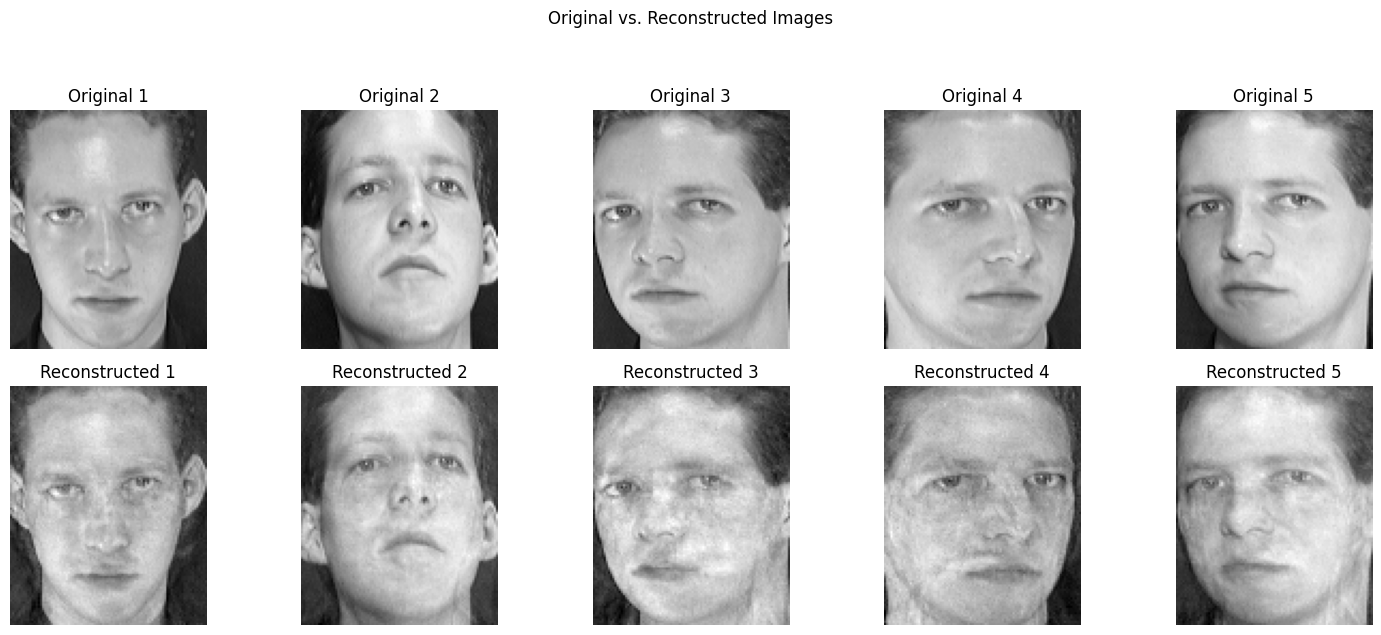

In [ ]:
original_images = original_images.numpy()
reconstructed_images = reconstructed_images.numpy()
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    axs[0, i].imshow(original_images[i].reshape(112, 92), cmap='gray')
    axs[0, i].set_title(f"Original {i+1}")
    axs[0, i].axis('off')

    # Reconstructed images
    axs[1, i].imshow(reconstructed_images[i].reshape(112, 92), cmap='gray')
    axs[1, i].set_title(f"Reconstructed {i+1}")
    axs[1, i].axis('off')

plt.suptitle("Original vs. Reconstructed Images", y=1.05)
plt.tight_layout()
plt.show()

## Gaussian Mixture Model with AutoEncoders